In [1]:
# How to size your bets
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline
from pathlib import Path

import numpy as np
from numpy.linalg import inv
from numpy.random import dirichlet
import pandas as pd

from sympy import symbols, solve, log, diff
from scipy.optimize import minimize_scalar, newton, minimize
from scipy.integrate import quad
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
sns.set_style('whitegrid')
np.random.seed(42)

In [5]:
DATA_STORE = Path('/Volumes/My Book/Data_Analysis', 'Nasdaq', 'assets.h5')

In [6]:
# The optimal size of a bet
share, odds, probability = symbols('share odds probability')
Value = probability * log(1 + odds * share) + (1 - probability) * log(1 - share)
solve(diff(Value, share), share)

[(odds*probability + probability - 1)/odds]

In [7]:
f, p = symbols('f p')
y = p * log(1 + f) + (1 - p) * log(1 - f)
solve(diff(y, f), f)

[2*p - 1]

In [8]:
# Get S&P 500 Data
with pd.HDFStore(DATA_STORE) as store:
    sp500 = store['sp500/stooq'].close

In [9]:
annual_returns = sp500.resample('A').last().pct_change().dropna().to_frame('sp500')

In [10]:
return_params = annual_returns.sp500.rolling(25).agg(['mean', 'std']).dropna()

In [11]:
return_ci = (return_params[['mean']]
                .assign(lower=return_params['mean'].sub(return_params['std'].mul(2)))
                .assign(upper=return_params['mean'].add(return_params['std'].mul(2))))

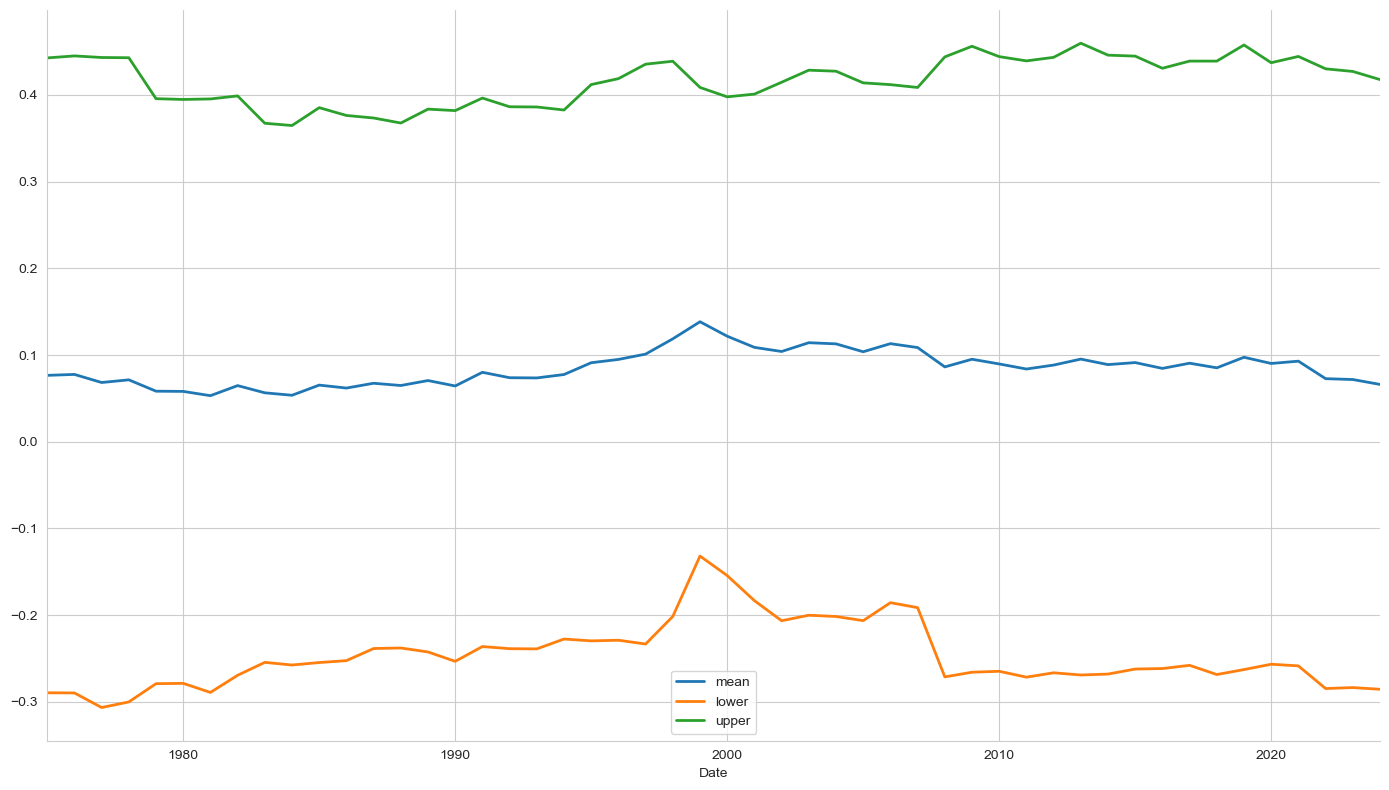

In [12]:
return_ci.plot(lw=2, figsize=(14, 8))
plt.tight_layout()
sns.despine();

In [13]:
# Kelly Rule for a Single Asset - Index Returns
def norm_integral(f, mean, std):
    val, er = quad(lambda s: np.log(1 + f * s) * norm.pdf(s, mean, std), 
                               mean - 3 * std, 
                               mean + 3 * std)
    return -val

In [24]:
def norm_dev_integral(f, mean, std):
    val, er = quad(lambda s: (s / (1 + f * s)) * norm.pdf(s, mean, std), m-3*std, mean+3*std)
    return val

In [14]:
def get_kelly_share(data):
    solution = minimize_scalar(norm_integral, 
                        args=(data['mean'], data['std']), 
                        bounds=[0, 2], 
                        method='bounded') 
    return solution.x

In [15]:
annual_returns['f'] = return_params.apply(get_kelly_share, axis=1)

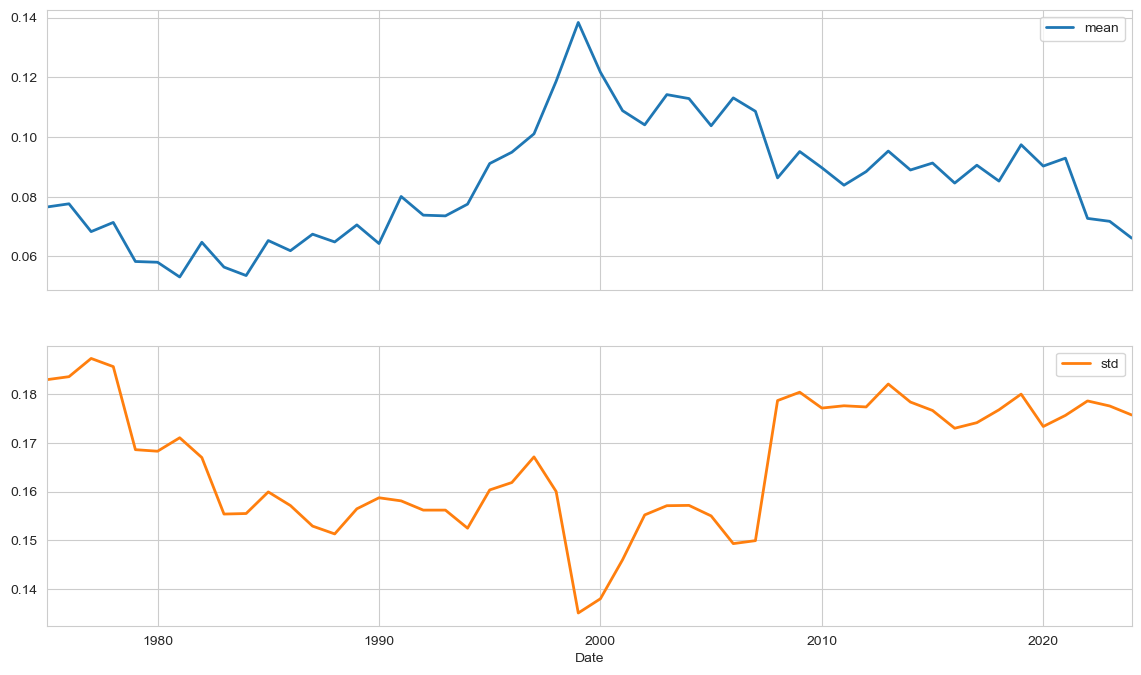

In [16]:
return_params.plot(subplots=True, lw=2, figsize=(14, 8));

In [17]:
annual_returns.tail()

,sp500,f
Date,,
2020-12-31,0.162589,1.999996
2021-12-31,0.268927,1.999996
2022-12-31,-0.194428,1.994368
2023-12-31,0.242305,1.996367
2024-12-31,0.053834,1.923354


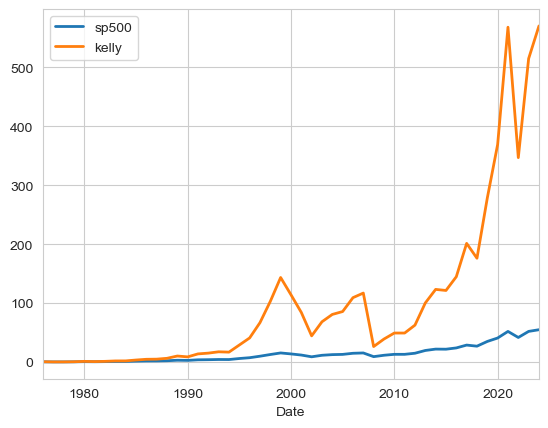

In [18]:
# Performance Evaluation
(annual_returns[['sp500']]
 .assign(kelly=annual_returns.sp500.mul(annual_returns.f.shift()))
 .dropna()
 .loc['1900':]
 .add(1)
 .cumprod()
 .sub(1)
 .plot(lw=2));

In [19]:
annual_returns.f.describe()

count    50.000000
mean      1.979405
std       0.059793
min       1.708206
25%       1.999996
50%       1.999996
75%       1.999996
max       1.999996
Name: f, dtype: float64

In [20]:
return_ci.head()

,mean,lower,upper
Date,,,
1975-12-31,0.076574,-0.289442,0.442591
1976-12-31,0.077649,-0.289600,0.444897
1977-12-31,0.068336,-0.306402,0.443074
1978-12-31,0.071410,-0.299973,0.442794
1979-12-31,0.058325,-0.278930,0.395581


In [21]:
# Compute Kelly Fraction
m = .058
s = .216

In [22]:
# Option 1: minimize the expectation integral
sol = minimize_scalar(norm_integral, args=(m, s), bounds=[0., 2.], method='bounded')
print('Optimal Kelly fraction: {:.4f}'.format(sol.x))

Optimal Kelly fraction: 1.1974


In [25]:
# Option 2: take the derivative of the expectation and make it null
x0 = newton(norm_dev_integral, .1, args=(m, s))
print('Optimal Kelly fraction: {:.4f}'.format(x0))

Optimal Kelly fraction: 1.1974


In [26]:
# Kelly Rule for Multiple Assets
with pd.HDFStore(DATA_STORE) as store:
    sp500_stocks = store['sp500/stocks'].index 
    prices = store['quandl/wiki/prices'].adj_close.unstack('ticker').filter(sp500_stocks)

In [27]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14277 entries, 1962-01-02 to 2018-03-27
Columns: 449 entries, MMM to ZTS
dtypes: float64(449)
memory usage: 49.0 MB


In [45]:
monthly_returns = prices.loc['1988':'2017'].resample('M').last().pct_change().dropna(how='all').dropna(axis=1)
stocks = monthly_returns.columns
monthly_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 359 entries, 1988-02-29 to 2017-12-31
Freq: M
Columns: 188 entries, MMM to XEL
dtypes: float64(188)
memory usage: 530.1 KB


In [53]:
# Compute Precision Matrix
cov = monthly_returns.cov()
precision_matrix = pd.DataFrame(inv(cov), index=stocks, columns=stocks)
# precision_matrix

ticker,MMM,AOS,ABT,ADBE,AMD,AFL,APD,LNT,MO,AEP,...,DIS,WEC,WFC,WST,WDC,WY,WHR,WMB,GWW,XEL
ticker,,,,,,,,,,,,,,,,,,,,,
MMM,1678.090480,-32.390593,189.016413,8.019053,-21.794431,-19.846391,-118.546438,-116.802711,-115.731568,87.911890,...,147.340646,-158.981659,-13.054165,-3.281020,-46.030934,-201.060235,-43.396963,-0.423845,17.425103,-19.897628
AOS,-32.390593,340.368348,-106.173262,30.306123,-1.164775,10.112963,21.100481,-49.232222,-17.726492,70.722015,...,16.720112,4.898096,14.271976,-55.638841,9.505476,17.496823,-28.380081,-13.577643,23.809837,52.911853
ABT,189.016413,-106.173262,1193.885915,-89.637449,-14.557578,-19.924696,33.947101,-96.613790,-103.726816,-29.600157,...,-18.203960,60.226650,-98.099573,128.313891,-60.057955,-101.237549,56.109598,-22.418811,-0.273117,89.586437
ADBE,8.019053,30.306123,-89.637449,223.580688,-0.076073,-50.224339,6.747665,61.841465,8.385551,60.633853,...,21.306191,90.627888,36.086337,-22.310248,24.243441,-21.272700,-53.607766,4.854193,-38.911323,-122.824969
AMD,-21.794431,-1.164775,-14.557578,-0.076073,96.040763,-18.890305,-10.550887,-21.863565,15.809905,-18.519992,...,-1.177530,30.692940,-65.781257,9.865729,-39.490332,15.999861,5.062385,-21.233935,-2.328007,15.464744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WY,-201.060235,17.496823,-101.237549,-21.272700,15.999861,27.961412,10.291272,0.461737,104.213289,-136.146811,...,-46.786107,-71.837261,43.969112,-1.052079,29.523166,841.846776,-27.485966,4.685492,-4.533452,13.330396
WHR,-43.396963,-28.380081,56.109598,-53.607766,5.062385,43.790563,22.225163,53.031114,-53.569175,-225.380492,...,27.850239,-10.776245,-36.644929,60.310700,-43.174855,-27.485966,543.597461,-21.033949,107.035793,91.393172
WMB,-0.423845,-13.577643,-22.418811,4.854193,-21.233935,8.592022,67.065813,61.558455,-65.468278,-23.611446,...,-59.820797,19.705429,4.307796,35.275862,23.494893,4.685492,-21.033949,306.913160,36.151806,-145.399261


In [30]:
kelly_allocation = monthly_returns.mean().dot(precision_matrix)

In [54]:
print(kelly_allocation.describe())
# print(kelly_allocation['L'])
# print(kelly_allocation['FRT'])
# print(kelly_allocation.max())
# kelly_allocation

count    188.000000
mean       0.252328
std        3.181840
min       -8.794847
25%       -1.725170
50%        0.197395
75%        2.051245
max        9.402337
dtype: float64


ticker
MMM     3.183618
AOS     3.086697
ABT    -0.317418
ADBE    0.336987
AMD    -0.485706
          ...   
WY     -3.007484
WHR    -0.608106
WMB    -2.227607
GWW    -1.903559
XEL    -6.230778
Length: 188, dtype: float64

In [32]:
kelly_allocation.sum()

47.4376962224479

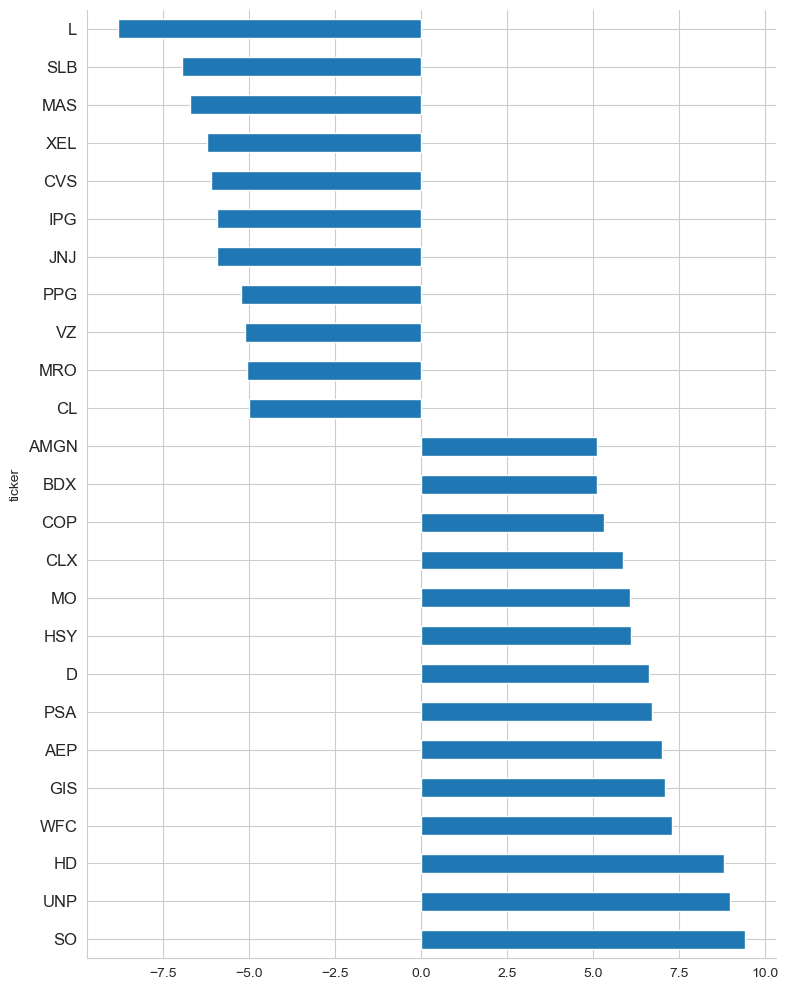

In [33]:
# Largest Portfolio Allocation => The plot shows the tickers that receive an allocation weight > 5x their value:
kelly_allocation[kelly_allocation.abs()>5].sort_values(ascending=False).plot.barh(figsize=(8, 10))
plt.yticks(fontsize=12)
sns.despine()
plt.tight_layout();

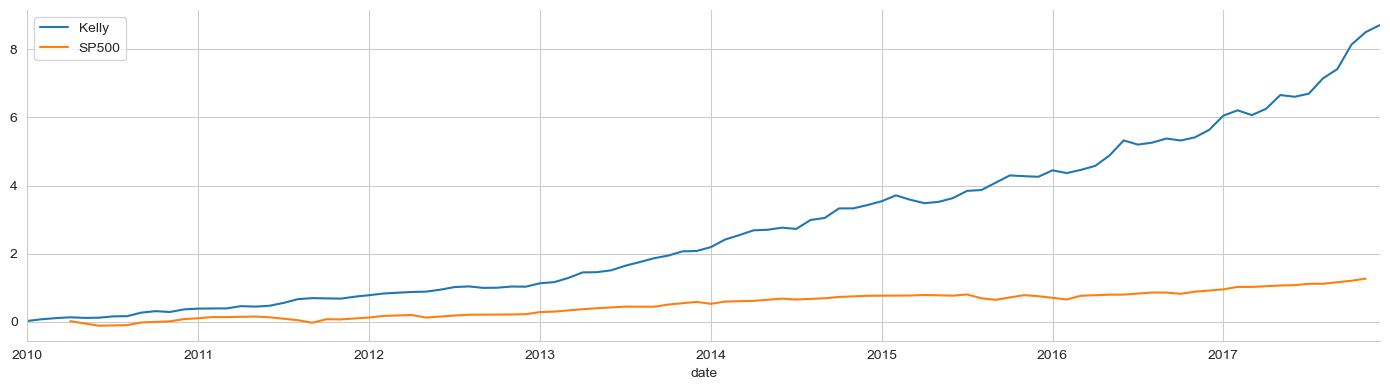

In [34]:
# Performance vs SP500. -- The Kelly rule does really well. But it has also been computed from historical data.
ax = monthly_returns.loc['2010':].mul(kelly_allocation.div(kelly_allocation.sum())).sum(1).to_frame('Kelly').add(1).cumprod().sub(1).plot(figsize=(14,4));
sp500.filter(monthly_returns.loc['2010':].index).pct_change().add(1).cumprod().sub(1).to_frame('SP500').plot(ax=ax, legend=True)
plt.tight_layout()
sns.despine();